# Specificity of EVODEX Operators in Michael Addition

This notebook tests the ability of EVODEX operator abstractions—Core (C), Nearest (N), and Electronic (E)—to discriminate between mechanistically reactive and non-reactive substrates in a Michael addition context.

We begin by extracting C/N/E operators for a canonical Michael addition reaction. These operators are then projected onto a series of related substrates, some of which are true Michael acceptors and others that are structurally similar but mechanistically inert. By comparing which substrates are matched at each abstraction level, we demonstrate that only the Electronic (E) abstraction captures the orbital features necessary to distinguish true reactivity.

This provides a focused, reaction-specific illustration of why E-level operators are necessary for accurate mechanistic modeling in EVODEX.:

In [ ]:
# Installation of the EVODEX library
!pip install evodex

# Additional imports used in this notebook
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions


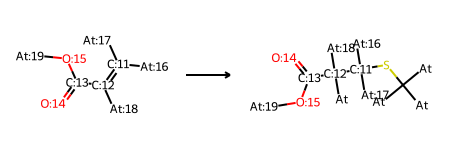

In [ ]:
# Input SMIRKS for a Michael addition-like reaction
rxn_smiles = "[C:11]([At:16])([At:17])=[C:12]([At:18])[C:13](=[O:14])[O:15]([At:19])>>[C]([At])([At])([At])[S][C:11]([At:16])([At:17])[C:12]([At])([At:18])[C:13](=[O:14])[O:15]([At:19])"
rxn = rdChemReactions.ReactionFromSmarts(rxn_smiles, useSmiles=True)
rxn


In [ ]:
import pandas as pd
from evodex.operators import extract_operator
from evodex.astatine import convert_dataframe_smirks_column_at_to_h

# Define extraction settings
c_settings = dict(
    include_stereochemistry=True,
    include_sigma=False,
    include_pi=False,
    include_unmapped_hydrogens=True,
    include_unmapped_heavy_atoms=True,
    include_static_hydrogens=True
)

n_settings = dict(
    include_stereochemistry=True,
    include_sigma=True,
    include_pi=False,
    include_unmapped_hydrogens=True,
    include_unmapped_heavy_atoms=True,
    include_static_hydrogens=True
)

e_settings = dict(
    include_stereochemistry=True,
    include_sigma=True,
    include_pi=True,
    include_unmapped_hydrogens=True,
    include_unmapped_heavy_atoms=True,
    include_static_hydrogens=True
)

# Extract raw operators with [At]
raw_operators = []
try:
    raw_operators.append(("EVODEX-C", extract_operator(rxn_smiles, **c_settings)))
    raw_operators.append(("EVODEX-N", extract_operator(rxn_smiles, **n_settings)))
    raw_operators.append(("EVODEX-E", extract_operator(rxn_smiles, **e_settings)))
except Exception as e:
    print(f"[!] Extraction error: {e}")

# Create DataFrame
df_raw = pd.DataFrame(raw_operators, columns=["Operator", "SMIRKS"])

# Convert [At] → [H]
df_converted, errors = convert_dataframe_smirks_column_at_to_h(df_raw, column_name="SMIRKS")

# Display result
df_converted

,Operator,SMIRKS
0,EVODEX-C,[#6:11]=[#6:12]>>[#6](-[H])(-[H])(-[H])-[#16]-...
1,EVODEX-N,[#6:11](-[H:16])(-[H:17])=[#6:12](-[H:18])-[#6...
2,EVODEX-E,[#6:11](-[H:16])(-[H:17])=[#6:12](-[H:18])-[#6...


EVODEX-C


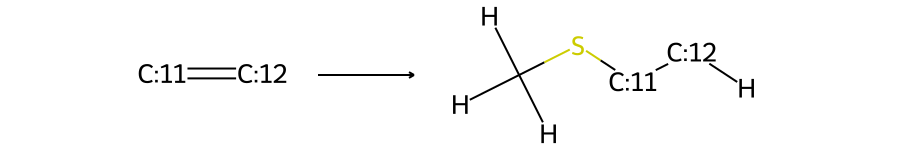

EVODEX-N


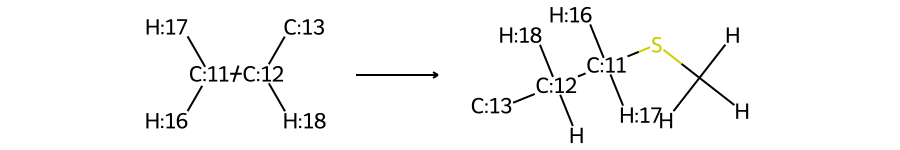

EVODEX-E


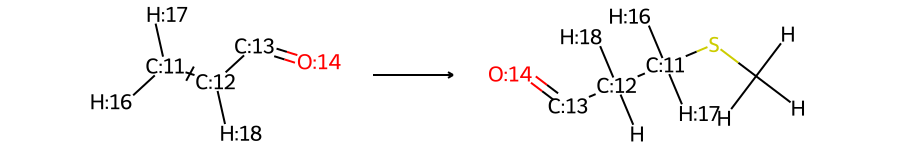

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions

# Display the 3 EVODEX operators as reaction images
reaction_images = []

for _, row in df_converted.iterrows():
    label = row["Operator"]
    smirks = row["SMIRKS"]
    try:
        rxn = rdChemReactions.ReactionFromSmarts(smirks)
        img = Draw.ReactionToImage(rxn, subImgSize=(300, 150))
        reaction_images.append((label, img))
    except Exception as e:
        print(f"[!] Could not render {label}: {e}")

# Display all reaction images in order
for label, img in reaction_images:
    print(label)
    display(img)

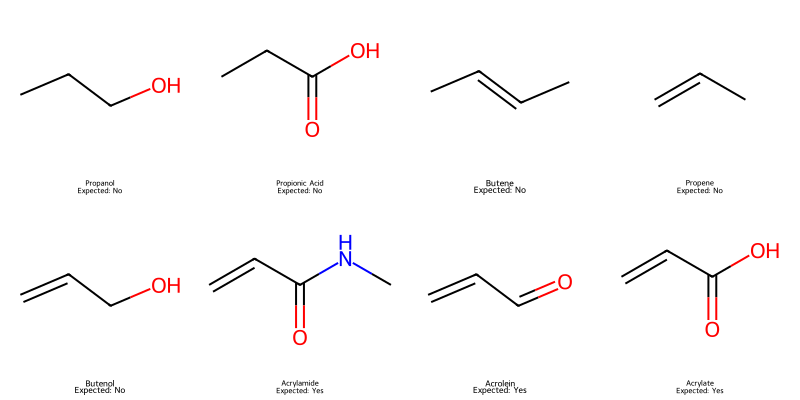

In [ ]:
from evodex.projection import project_operator
from rdkit import Chem
import pandas as pd

# Define substrates as (name, SMILES, expected_reactivity)
substrates_raw = [
    ("Propanol", 'CCCO', False),
    ("Propionic Acid", 'CCC(=O)O', False),
    ("Butene", 'CC=CC', False),
    ("Propene", 'C=CC', False),
    ("Butenol", 'C=CCO', False),
    ("Acrylamide", 'C=CC(=O)NC', True),
    ("Acrolein", 'C=CC=O', True),
    ("Acrylate", 'C=CC(=O)O', True),
]

# Preprocess: canonicalize and record expectations
substrates = []
expecteds = {}
for name, smiles, expected in substrates_raw:
    mol = Chem.MolFromSmiles(smiles)
    smiles_with_h = Chem.MolToSmiles(mol)
    substrates.append((name, smiles_with_h))
    expecteds[name] = expected

from rdkit.Chem import Draw

# Prepare molecule objects with labels
mols = []
legends = []

for name, smiles in substrates:
    mol = Chem.MolFromSmiles(smiles)
    mols.append(mol)
    label = f"{name}\nExpected: {'Yes' if expecteds[name] else 'No'}"
    legends.append(label)

# Display molecules with names and expected reactivity
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)

In [ ]:

# Run projection across all operators and substrates
results = []

for _, row in df_converted.iterrows():
    op_label = row["Operator"]
    smirks = row["SMIRKS"]
    print(f"\n{op_label} {smirks}\n")

    for name, smiles in substrates:
        print(name, smiles)
        try:
            match = project_operator(smirks, smiles)
            print(match)
            hit = "✓" if match else "×"
        except Exception as e:
            hit = "error"
        results.append((op_label, name, hit))

# Format results as DataFrame
df_matrix = pd.DataFrame(results, columns=["Operator", "Substrate", "Match"])
df_matrix_pivot = df_matrix.pivot(index="Substrate", columns="Operator", values="Match")

# Preserve substrate order
substrate_order = [name for name, _, _ in substrates_raw]
df_matrix_pivot = df_matrix_pivot.reindex(index=substrate_order)

# Compute accuracy row
accuracy_row = {}
for op in df_matrix_pivot.columns:
    correct = 0
    total = 0
    for name in df_matrix_pivot.index:
        predicted = df_matrix_pivot.loc[name, op]
        if predicted not in {"✓", "×"}:
            continue
        expected = expecteds[name]
        if (predicted == "✓" and expected) or (predicted == "×" and not expected):
            correct += 1
        total += 1
    accuracy_row[op] = f"{correct}/{total}"

# Append accuracy as final row
df_matrix_pivot.loc["(Accuracy)"] = pd.Series(accuracy_row)

# Display the final table
df_matrix_pivot


EVODEX-C [#6:11]=[#6:12]>>[#6](-[H])(-[H])(-[H])-[#16]-[#6:11]-[#6:12]-[H]

Propanol CCCO
[]
Propionic Acid CCC(=O)O
[]
Butene CC=CC
['[H]C([H])([H])SC([H])(C([H])([H])[H])C([H])([H])C([H])([H])[H]']
Propene C=CC
['[H]C([H])([H])SC([H])(C([H])([H])[H])C([H])([H])[H]', '[H]C([H])([H])SC([H])([H])C([H])([H])C([H])([H])[H]']
Butenol C=CCO
['[H]OC([H])([H])C([H])(SC([H])([H])[H])C([H])([H])[H]', '[H]OC([H])([H])C([H])([H])C([H])([H])SC([H])([H])[H]']
Acrylamide C=CC(=O)NC
['[H]N(C(=O)C([H])(SC([H])([H])[H])C([H])([H])[H])C([H])([H])[H]', '[H]N(C(=O)C([H])([H])C([H])([H])SC([H])([H])[H])C([H])([H])[H]']
Acrolein C=CC=O
['[H]C(=O)C([H])([H])C([H])([H])SC([H])([H])[H]', '[H]C(=O)C([H])(SC([H])([H])[H])C([H])([H])[H]']
Acrylate C=CC(=O)O
['[H]OC(=O)C([H])([H])C([H])([H])SC([H])([H])[H]', '[H]OC(=O)C([H])(SC([H])([H])[H])C([H])([H])[H]']

EVODEX-N [#6:11](-[H:16])(-[H:17])=[#6:12](-[H:18])-[#6:13]>>[#6](-[H])(-[H])(-[H])-[#16]-[#6:11](-[H:16])(-[H:17])-[#6:12](-[H])(-[H:18])-[#6:13]

Propanol 

Operator,EVODEX-C,EVODEX-E,EVODEX-N
Substrate,,,
Propanol,×,×,×
Propionic Acid,×,×,×
Butene,✓,×,×
Propene,✓,×,✓
Butenol,✓,×,✓
Acrylamide,✓,✓,✓
Acrolein,✓,✓,✓
Acrylate,✓,✓,✓
(Accuracy),5/8,8/8,6/8
